In [ ]:
import category_encoders as ce
import community as community_louvain
import networkx as nx
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.auto import tqdm


/opt/anaconda/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_test = pd.read_csv("test_data/fraudTest.csv", index_col=0)
df = pd.read_csv("test_data/fraudTrain.csv", index_col=0)

In [3]:
df = pd.concat([df, df_test])

In [4]:
df.shape

(1852394, 22)

In [5]:
def initial_data_process(df):
    # –ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ –¥–∞–Ω–Ω—ã—Ö –∫ datetime
    df["trans_date_trans_time"] = pd.to_datetime(
        df["trans_date_trans_time"], errors="coerce"
    )
    df["dob"] = pd.to_datetime(df["dob"], errors="coerce")

    # –§—É–Ω–∫—Ü–∏—è –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏—è —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –º–µ–∂–¥—É —Ç–æ—á–∫–∞–º–∏
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        phi1, phi2 = np.radians(lat1), np.radians(lat2)
        dphi = np.radians(lat2 - lat1)
        dlambda = np.radians(lon2 - lon1)
        a = (
            np.sin(dphi / 2) ** 2
            + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
        )
        return 2 * R * np.arcsin(np.sqrt(a))

    # –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ –±–∞–∑–æ–≤—ã—Ö –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    df["hour"] = df["trans_date_trans_time"].dt.hour
    df["dayofweek"] = df["trans_date_trans_time"].dt.day_name()
    df["month"] = df["trans_date_trans_time"].dt.month

    # –ü–æ–ª—É—á–µ–Ω–∏–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è –º–µ–∂–¥—É –∫–ª–∏–µ–Ω—Ç–æ–º –∏ –º–∞–≥–∞–∑–∏–Ω–æ–º
    df["distance_km"] = haversine(
        df["lat"], df["long"], df["merch_lat"], df["merch_long"]
    )

    # –í–æ–∑—Ä–∞—Å—Ç –∫–ª–∏–µ–Ω—Ç–∞ –Ω–∞ –º–æ–º–µ–Ω—Ç —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ –¥–∞—Ç—ã —Ä–æ–∂–¥–µ–Ω–∏—è
    df["age"] = df.apply(
        lambda row: row["trans_date_trans_time"].year
        - row["dob"].year
        - (
            (row["trans_date_trans_time"].month, row["trans_date_trans_time"].day)
            < (row["dob"].month, row["dob"].day)
        ),
        axis=1,
    )

    return df


df = initial_data_process(df)

# EDA

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
print("Shape:", df.shape)
print("Data types:\n", df.dtypes)

Shape: (1852394, 27)
Data types:
 trans_date_trans_time    datetime64[ns]
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
hour                              int32
dayofweek                        object
month 

In [8]:
print("Missing values per column:\n", df.isna().sum())
print("Duplicate rows:", df.duplicated().sum())

Missing values per column:
 trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
hour                     0
dayofweek                0
month                    0
distance_km              0
age                      0
dtype: int64
Duplicate rows: 0


In [9]:
df.describe()

trans_date_trans_time        cc_num           amt  \
count                        1852394  1.852394e+06  1.852394e+06   
mean   2020-01-20 21:31:46.801827328  4.173860e+17  7.006357e+01   
min              2019-01-01 00:00:18  6.041621e+10  1.000000e+00   
25%    2019-07-23 04:13:43.750000128  1.800429e+14  9.640000e+00   
50%              2020-01-02 01:15:31  3.521417e+15  4.745000e+01   
75%    2020-07-23 12:11:25.249999872  4.642255e+15  8.310000e+01   
max              2020-12-31 23:59:34  4.992346e+18  2.894890e+04   
std                              NaN  1.309115e+18  1.592540e+02   

                zip           lat          long      city_pop  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   4.881326e+04  3.853931e+01 -9.022783e+01  8.864367e+04   
min    1.257000e+03  2.002710e+01 -1.656723e+02  2.300000e+01   
25%    2.623700e+04  3.466890e+01 -9.679800e+01  7.410000e+02   
50%    4.817400e+04  3.935430e+01 -8.747690e+01  2.443000e+03   
75%    7.204200e+04  4.194040e+01 -8.015800e+01  2.032800e+04   
max    9.992100e+04  6.669330e+01 -6.795030e+01  2.906700e+06   
std    2.688185e+04  5.071470e+00  1.374789e+01  3.014876e+05   

                                 dob     unix_time     merch_lat  \
count                        1852394  1.852394e+06  1.852394e+06   
mean   1973-10-15 11:05:05.744458256  1.358674e+09  3.853898e+01   
min              1924-10-30 00:00:00  1.325376e+09  1.902742e+01   
25%              1962-08-13 00:00:00  1.343017e+09  3.474012e+01   
50%              1975-11-30 00:00:00  1.357089e+09  3.936890e+01   
75%              1987-04-23 00:00:00  1.374581e+09  4.195626e+01   
max              2005-01-29 00:00:00  1.388534e+09  6.751027e+01   
std                              NaN  1.819508e+07  5.105604e+00   

         merch_long      is_fraud          hour         month   distance_km  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean  -9.022794e+01  5.210015e-03  1.280612e+01  7.152067e+00  7.611173e+01   
min   -1.666716e+02  0.000000e+00  0.000000e+00  1.000000e+00  2.225452e-02   
25%   -9.689944e+01  0.000000e+00  7.000000e+00  4.000000e+00  5.532009e+01   
50%   -8.744069e+01  0.000000e+00  1.400000e+01  7.000000e+00  7.821638e+01   
75%   -8.024511e+01  0.000000e+00  1.900000e+01  1.000000e+01  9.850947e+01   
max   -6.695090e+01  1.000000e+00  2.300000e+01  1.200000e+01  1.521172e+02   
std    1.375969e+01  7.199217e-02  6.815753e+00  3.424954e+00  2.911697e+01   

                age  
count  1.852394e+06  
mean   4.576496e+01  
min    1.300000e+01  
25%    3.200000e+01  
50%    4.400000e+01  
75%    5.700000e+01  
max    9.600000e+01  
std    1.741240e+01

## –°—É–º–º–∞ —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π

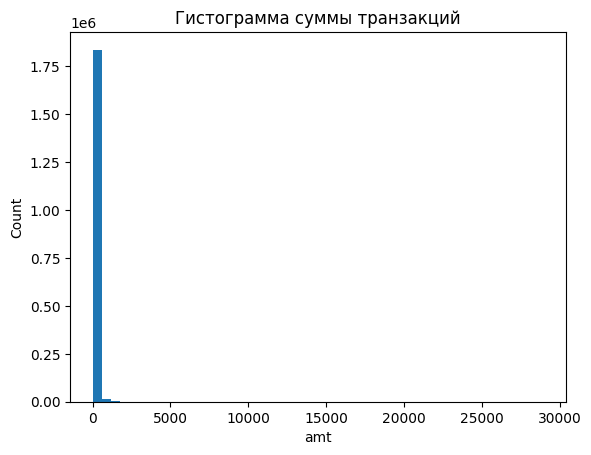

In [10]:
plt.figure()
plt.hist(df["amt"].dropna(), bins=50)
plt.title("–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Å—É–º–º—ã —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π")
plt.xlabel("amt")
plt.ylabel("Count")
plt.show()

In [11]:
df[df["amt"] > 1500]["is_fraud"].value_counts()

is_fraud
0    1903
Name: count, dtype: int64

–í–∏–¥–∏–º, —á—Ç–æ —É –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π –æ—á–µ–Ω—å –±–æ–ª—å—à–æ–π —Ö–≤–æ—Å—Ç, –ø—Ä–∏ —ç—Ç–æ–º –º–æ—à–µ–Ω–Ω–∏—á–µ—Å–∫–∏—Ö —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π —Ç–∞–º –Ω–µ—Ç. –£–¥–∞–ª–∏–º –≤—Å–µ —Å—Ç—Ä–æ–∫–∏, –≤ –∫–æ—Ç–æ—Ä—ã—Ö —Å—É–º–º–∞ —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–∏ > 1500, —Ç–∞–∫ –∫–∞–∫ –æ–Ω–∏ —Å–æ—Å—Ç–∞–≤–ª—è—é—Ç 0.1% –æ—Ç –æ–±—â–µ–≥–æ —á–∏—Å–ª–∞ –∑–∞–ø–∏—Å–µ–π. –ü—Ä–∏ —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–µ —Å–∏—Å—Ç–µ–º—ã –Ω–∞—á–∏–Ω–∞—è —Å –Ω–µ–∫–æ—Ç–æ—Ä–æ–≥–æ –ø–æ—Ä–æ–≥–∞ –º–æ–∂–Ω–æ –±—É–¥–µ—Ç –ø–æ–º–µ—á–∞—Ç—å —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–∏ –∫–∞–∫ –ø–æ–¥–æ–∑—Ä–∏—Ç–µ–ª—å–Ω—ã–µ, –Ω–æ –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ –∞–ª–≥–æ—Ä–∏—Ç–º–∞ —ç—Ç–∏ –¥–∞–Ω–Ω—ã–µ –±–µ—Å–ø–æ–ª–µ–∑–Ω—ã.

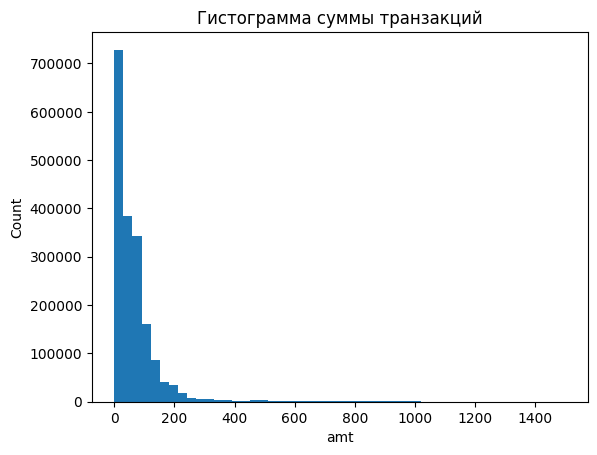

In [12]:
df = df[df["amt"] < 1500]
plt.figure()
plt.hist(df["amt"].dropna(), bins=50)
plt.title("–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Å—É–º–º—ã —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π")
plt.xlabel("amt")
plt.ylabel("Count")
plt.show()

## –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏

In [13]:
cat_cols = ["category", "merchant", "state", "job", "gender"]
full_fraud = {}
for col in cat_cols:
    print(f"\n–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ {col}:")
    print(df[col].value_counts().head(10))
    print("-" * 50)

    fraud_ratio = (
        df.groupby(col)["is_fraud"].mean().sort_values(ascending=False).head(20)
    )
    if any(fraud_ratio == 1):
        full_fraud[col] = fraud_ratio[fraud_ratio == 1].index.tolist()
    print(f"–î–æ–ª—è –º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–∞ –¥–ª—è —Ç–æ–ø-10 –ø–æ {col}:")
    print(fraud_ratio)
    print("-" * 100)


–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ category:
category
gas_transport     188029
grocery_pos       176191
home              175460
shopping_pos      165756
kids_pets         161727
shopping_net      138816
entertainment     134118
food_dining       130729
personal_care     130085
health_fitness    122553
Name: count, dtype: int64
--------------------------------------------------
–î–æ–ª—è –º–æ—à–µ–Ω–Ω–∏—á–µ—Å—Ç–≤–∞ –¥–ª—è —Ç–æ–ø-10 –ø–æ category:
category
shopping_net      0.015985
misc_net          0.013048
grocery_pos       0.012645
shopping_pos      0.006371
gas_transport     0.004106
misc_pos          0.002821
travel            0.002717
grocery_net       0.002697
personal_care     0.002229
entertainment     0.002177
kids_pets         0.001880
food_dining       0.001568
home              0.001510
health_fitness    0.001510
Name: is_fraud, dtype: float64
----------------------------------------------------------------------------------------------------

–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–

In [14]:
print(full_fraud)
total_fraud_in_data = df["is_fraud"].sum()
total = 0
for category, values in full_fraud.items():
    print(f"\nCategory: {category}")
    for value in values:
        count = (df[category] == value).sum()
        fraud_count = df[(df[category] == value) & (df["is_fraud"] == 1)].shape[0]
        total += fraud_count
        print(f"  {value}: {count} occurrences")
    print(f"Total fraud count for {category}: {total}")
    print(f"Fraud percentage for {category}: {total / total_fraud_in_data:.2%}")
    print("-" * 100)


{'state': ['DE'], 'job': ['Air traffic controller', 'Careers adviser', 'Broadcast journalist', 'Armed forces technical officer', 'Contracting civil engineer', 'Sales promotion account executive', 'Ship broker', 'Software engineer', 'Solicitor', 'Dancer', 'Legal secretary', 'Accountant, chartered', 'Veterinary surgeon', 'Engineer, water', 'Engineer, site', 'Operational investment banker', 'Personnel officer', 'Forest/woodland manager', 'Homeopath', 'Industrial buyer']}

Category: state
  DE: 9 occurrences
Total fraud count for state: 9
Fraud percentage for state: 0.09%
----------------------------------------------------------------------------------------------------

Category: job
  Air traffic controller: 17 occurrences
  Careers adviser: 15 occurrences
  Broadcast journalist: 9 occurrences
  Armed forces technical officer: 8 occurrences
  Contracting civil engineer: 7 occurrences
  Sales promotion account executive: 14 occurrences
  Ship broker: 7 occurrences
  Software engineer: 11

–í–∏–¥–Ω–æ, —á—Ç–æ –µ—Å—Ç—å –∫–∞—Ç–µ–≥–æ—Ä–∏–∏, –≤ –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –∫–æ—Ç–æ—Ä—ã—Ö –≤—Å–µ –∑–∞–ø–∏—Å–∏ —è–≤–ª—è—é—Ç—Å—è –º–æ—à–µ–Ω–Ω–∏—á–µ—Å–∫–∏–º–∏. –û—á–µ–≤–∏–¥–Ω—ã–º —Ä–µ—à–µ–Ω–∏–µ–º –±—ã–ª–æ –±—ã –∏—Å–∫–ª—é—á–∏—Ç—å —ç—Ç–∏ –∑–∞–ø–∏—Å–∏, –Ω–æ –≤ –¥–∞–Ω–Ω–æ–º –Ω–∞–±–æ—Ä–µ –¥–∞–Ω–Ω—ã—Ö –∑–∞–ø–∏—Å–∏ —Å–≤—è–∑–∞–Ω—ã –∫–∞–∫, —Ç–∞–∫ –∫–∞–∫ –æ–¥–∏–Ω –∏ —Ç–æ—Ç –∂–µ –∫–ª–∏–µ–Ω—Ç –ø–æ—è–≤–ª—è–µ—Ç—Å—è –≤ –Ω–∞–±–æ—Ä–µ –¥–∞–Ω–Ω—ã—Ö –±–æ–ª–µ–µ 1-–≥–æ —Ä–∞–∑–∞, –∫–∞–∫ –∏ –∫–∞–∂–¥—ã–π –º–∞–≥–∞–∑–∏–Ω, —Ñ–æ—Ä–º–∏—Ä—É—è –∏—Å—Ç–æ—Ä–∏—é –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π. –° —ç—Ç–∏–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏ –±—É–¥–µ–º –±–æ—Ä–æ—Ç—å—Å—è —Å –ø–æ–º–æ—â—å—é –ø–∞—Ä–∞–º–µ—Ç—Ä–∞ `smoothing` –≤ TargetEncoder

## –†–∞—Å—Å—Ç–æ—è–Ω–∏–µ

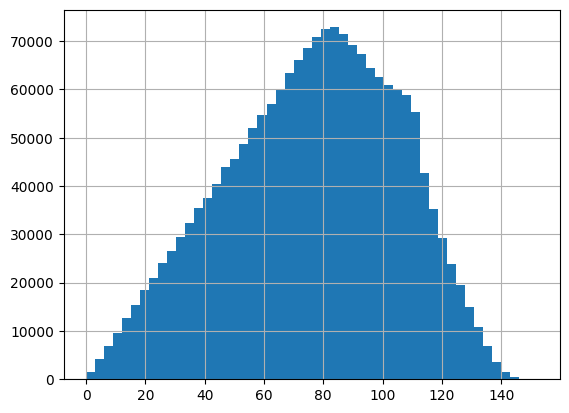

In [15]:
df["distance_km"].hist(bins=50)
plt.show()

–° —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ–º –≤—Å–µ –ø–æ—á—Ç–∏ –Ω–æ—Ä–º–∞–ª—å–Ω–æ (üôÇ)

## –í–æ–∑—Ä–∞—Å—Ç

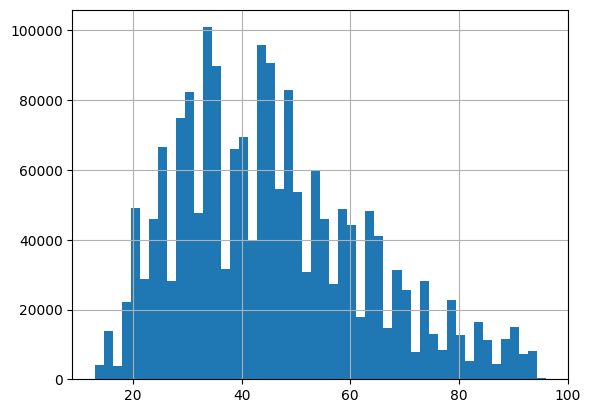

In [16]:
df["age"].hist(bins=50)
plt.show()

In [17]:
df["age"].value_counts().sort_index(ascending=False).head(20)

age
96       77
95      357
94     2560
93     5571
92     7181
91     7760
90     7112
89     6489
88     4982
87     4239
86     4842
85     6393
84     8545
83     7932
82     5183
81     4843
80     7801
79    10134
78    12452
77     8393
Name: count, dtype: int64

–í–æ–∑–º–æ–∂–Ω–æ, –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –≤–æ–∑—Ä–∞—Å—Ç—ã –≤–µ–ª–∏–∫–æ–≤–∞—Ç—ã, –Ω–æ –∂–∏—Ç—å –º–æ–∂–Ω–æ

## –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

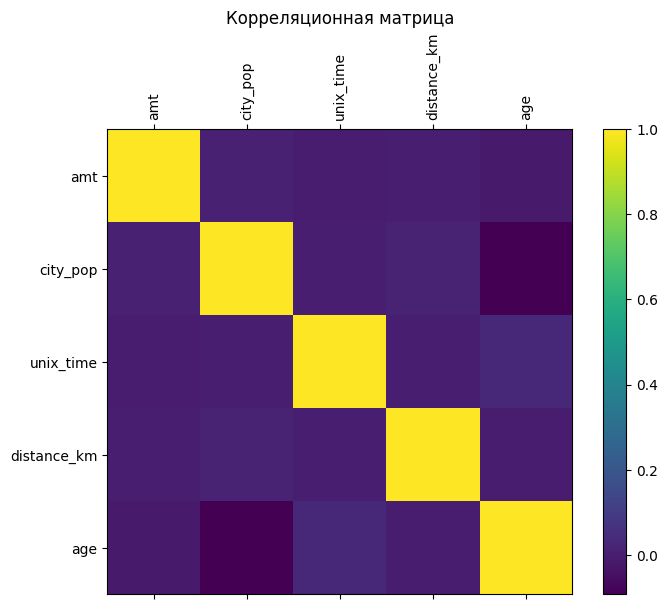

In [18]:
corr_cols = ["amt", "city_pop", "unix_time", "distance_km", "age"]
corr = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
plt.matshow(corr, fignum=1)
plt.title("–ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar()
plt.show()


## –î–∏–∑–±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤

In [19]:
df["is_fraud"].value_counts(normalize=True)

is_fraud
0    0.994785
1    0.005215
Name: proportion, dtype: float64

# Feature engeneering –∏ –æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö

–î–æ–±–∞–≤–∏–º –≤—Ä–µ–º–µ–Ω–Ω—ã–µ —Ñ–∏—á–∏, –∞ –∏–º–µ–Ω–Ω–æ:
1. –ß–∞—Å
2. –î–µ–Ω—å –Ω–µ–¥–µ–ª–∏
3. –ú–µ—Å—è—Ü
4. –§–ª–∞–≥ –Ω–æ—á–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏
5. –§–ª–∞–≥ —Ä–∞–±–æ—á–∏—Ö —á–∞—Å–æ–≤
6. –§–ª–∞–≥ –≤—ã—Ö–æ–¥–Ω—ã—Ö
7. –†–∞–∑–Ω–∏—Ü—É –≤–æ –≤—Ä–µ–º–µ–Ω–∏ –º–µ–∂–¥—É —Ç–µ–∫—É—â–µ–π –∏ –ø—Ä–µ–¥—ã–¥—É—â–µ–π —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–µ–π


–ü–æ—Å–ª–µ–¥–Ω–∏—é —Ñ–∏—á—É –¥–ª—è —Ç–µ—Å—Ç–∞ –±—É–¥–µ–º —Ä–∞—Å—Å—á–∏—Ç—ã–≤–∞—Ç—å —Å —É—á–µ—Ç–æ–º —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö, —Ç–∞–∫ –∫–∞–∫ —Ç–µ—Å—Ç - –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ–π —Ç—Ä–µ–π–Ω–∞ –≤–æ –≤—Ä–µ–º–µ–Ω–∏

In [20]:
def add_time_and_amount_features(
    df_train: pd.DataFrame, roll_windows: list[int] = [5]
) -> pd.DataFrame:
    # 0. –†–∞–±–æ—á–∞—è –∫–æ–ø–∏—è
    train = df_train.copy()

    # 1. –ë–∞–∑–æ–≤—ã–µ –≤—Ä–µ–º–µ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
    train["hour"] = train["trans_date_trans_time"].dt.hour
    train["dayofweek"] = train["trans_date_trans_time"].dt.day_name()
    train["month"] = train["trans_date_trans_time"].dt.month
    train["is_night"] = ((train["hour"] < 6) | (train["hour"] > 20)).astype(int)
    train["is_business_hour"] = ((train["hour"] >= 9) & (train["hour"] <= 18)).astype(
        int
    )
    train["is_weekend"] = train["dayofweek"].isin(["Saturday", "Sunday"]).astype(int)

    # 2. –í—Ä–µ–º–µ–Ω–Ω—ã–µ –¥–µ–ª—å—Ç—ã
    train = train.sort_values(["cc_num", "trans_date_trans_time"])
    train["prev_time"] = train.groupby("cc_num")["trans_date_trans_time"].shift()
    train["time_diff_h"] = (
        train["trans_date_trans_time"] - train["prev_time"]
    ).dt.total_seconds() / 3600
    # —è–≤–Ω–æ –∑–∞–ø–æ–ª–Ω—è–µ–º NaN
    median_td = train["time_diff_h"].median()
    train["time_diff_h"] = train["time_diff_h"].fillna(median_td)

    # 3. –ü—Ä–∏–∑–Ω–∞–∫–∏ –ø–æ —Å—É–º–º–∞–º
    amt_col = "amt"
    train["prev_amount"] = train.groupby("cc_num")[amt_col].shift()
    train["amount_diff"] = train[amt_col] - train["prev_amount"]
    train["amount_diff"] = train["amount_diff"].fillna(0)
    train["amount_ratio"] = train[amt_col] / train["prev_amount"].replace(0, 1)

    # 3.1 –°–∫–æ–ª—å–∑—è—â–∏–µ mean/std —á–µ—Ä–µ–∑ transform
    for w in roll_windows:
        train[f"roll_mean_amt_{w}"] = train.groupby("cc_num")[amt_col].transform(
            lambda s: s.shift().rolling(window=w, min_periods=1).mean()
        )
        train[f"roll_std_amt_{w}"] = train.groupby("cc_num")[amt_col].transform(
            lambda s: s.shift().rolling(window=w, min_periods=1).std().fillna(0)
        )

    # 4. –ü—Ä–∏–∑–Ω–∞–∫ "—É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö" –º–∞–≥–∞–∑–∏–Ω–æ–≤ –∑–∞ 30 –¥–Ω–µ–π
    #    –ø–µ—Ä–µ–∫–æ–¥–∏—Ä—É–µ–º merchant –≤ —Ü–∏—Ñ—Ä—ã
    train["merchant_code"] = train["merchant"].astype("category").cat.codes
    train = train.set_index("trans_date_trans_time")
    train["unique_merch_last_30d"] = (
        train.groupby("cc_num")["merchant_code"]
        .apply(
            lambda s: s.shift().rolling("30d").apply(lambda x: len(set(x)), raw=False)
        )
        .reset_index(level=0, drop=True)
    )
    train = train.reset_index()

    # 5. –§–∏–Ω–∞–ª—å–Ω—ã–µ —á–∏—Å—Ç–∫–∏
    train = train.drop(columns=["merchant_code"])
    train = train.fillna(0)

    return train


df = add_time_and_amount_features(df)

In [21]:
df["gender"] = df["gender"].map({"M": 0, "F": 1})


–ù–∏–∂–µ - –∫–ª–∞—Å—Å –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ –¥–∞–Ω–Ω—ã—Ö. –û–Ω –º–æ–∂–µ—Ç —Ä–∞–±–æ—Ç–∞—Ç—å –∫–∞–∫ —Å –≥—Ä–∞—Ñ–æ–≤—ã–º–∏ —Ñ–∏—á–∞–º–∏, —Ç–∞–∫ –∏ –±–µ–∑ –Ω–∏—Ö.
–û–Ω —Ä–µ–∞–ª–∏–∑—É–µ—Ç –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—é —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤, OHE –¥–ª—è —Ñ–∏—á–µ–π —Å –Ω–∏–∑–∫–æ–π –∫–∞—Ä–¥–∏–Ω–∞–ª—å–Ω–æ—Å—Ç—å—é –∏ TE –¥–ª—è —Ñ–∏—á–µ–π —Å –≤—ã—Å–æ–∫–æ–π –∫–∞—Ä–¥–∏–Ω–∞–ª—å–Ω–æ—Å—Ç—å—é, –∞ —Ç–∞–∫–∂–µ –∏–∑–º–µ–Ω—è–µ—Ç –±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤ –≤ –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–µ, —Ç–∞–∫ –∫–∞–∫ –¥–∞–Ω–Ω—ã–µ –æ—á–µ–Ω—å –Ω–µ—Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω—ã.

In [22]:
from typing import List, Tuple, Union

ALL_USED_COLUMNS = []
training_df = pd.DataFrame()
test_df = pd.DataFrame()
TARGET_FRAC = 0.001


class FraudDataPreprocessor:
    def __init__(
        self, graph_features: bool = False, random_state: int = 42, gnn_prepare=False
    ):
        """
        Parameters:
        - graph_features: whether to include graph-based numeric features
        - random_state: seed for reproducibility
        """
        self.graph_features = graph_features
        self.random_state = random_state
        self.gnn_prepare = gnn_prepare

        self.numeric_features: List[str] = []
        self.low_cardinal_feats: List[str] = []
        self.high_cardinal_feats: List[str] = []
        self.as_is_cols: List[str] = []
        self.low_ohe_cols: List[str] = []

        self.scaler: StandardScaler = None
        self.ohe: OneHotEncoder = None
        self.target_encoder: ce.TargetEncoder = None

    def fit(self, df: pd.DataFrame, y: pd.Series, n_splits: int = 5):
        numeric = [
            "amt",
            "city_pop",
            "distance_km",
            "age",
            "time_diff_h",
            "prev_amount",
            "amount_diff",
            "amount_ratio",
            "roll_mean_amt_5",
            "roll_std_amt_5",
            "unique_merch_last_30d",
        ]

        low_card = [
            "category",
            "dayofweek",
            "hour",
            "month",
        ]

        high_card = [
            "job",
            "state",
        ]

        as_is_feats = [
            "gender",
            "is_weekend",
            "is_business_hour",
            "is_night",
        ]

        if self.graph_features:
            numeric += ["c_deg", "c_comm_size", "m_deg", "m_comm_size"]
            high_card += ["c_comm", "m_comm"]
            as_is_feats += [c for c in df.columns if c.startswith("emb_")]

        if self.gnn_prepare:
            as_is_feats += ["cc_num", "merchant"]

        self.numeric_features = numeric
        self.low_cardinal_feats = low_card
        self.high_cardinal_feats = high_card
        self.as_is_cols = as_is_feats

        self.scaler = StandardScaler().fit(df[self.numeric_features])

        self.ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        self.ohe.fit(df[self.low_cardinal_feats])
        self.low_ohe_cols = self.ohe.get_feature_names_out(
            self.low_cardinal_feats
        ).tolist()

        self.target_encoder = ce.TargetEncoder(
            cols=self.high_cardinal_feats,
            smoothing=0.4,  # –ø–æ–∑–≤–æ–ª—è–µ—Ç –∏–∑–±–µ–∂–∞—Ç—å "–∑–∞–ø–æ–º–∏–Ω–∞–Ω–∏—è", –∫–æ–≥–¥–∞ –¥–ª—è –Ω–µ–∫–æ—Ç–æ—Ä–æ–≥–æ –∫–ª–∞—Å—Å–∞ –≤—Å–µ –ø—Ä–∏–º–µ—Ä—ã –∏–º–µ—é—Ç –æ–¥–∏–Ω–∞–∫–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ
        ).fit(df[self.high_cardinal_feats], y)

        return self

    def transform(
        self, df: pd.DataFrame
    ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        if any(obj is None for obj in (self.scaler, self.ohe, self.target_encoder)):
            raise RuntimeError("Run .fit() first")

        has_target = "is_fraud" in df.columns
        if has_target:
            y = df["is_fraud"].to_numpy()
            df = df.drop(columns="is_fraud")
        else:
            y = None

        X_as_is = df[self.as_is_cols].to_numpy() if self.as_is_cols else None

        X_num = self.scaler.transform(df[self.numeric_features])
        X_low = self.ohe.transform(df[self.low_cardinal_feats])
        X_high = self.target_encoder.transform(df[self.high_cardinal_feats]).values

        arrays = [X_num, X_low, X_high]
        if X_as_is is not None:
            arrays.append(X_as_is)

        X = np.hstack(arrays)

        return (X, y) if has_target else X

    def fit_transform(
        self, df: pd.DataFrame, test_size: float = 0.2
    ) -> Tuple[np.ndarray, np.ndarray, pd.Series, pd.Series]:
        y = df["is_fraud"]
        X = df.drop(columns=["is_fraud"])
        X_train, X_val, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=self.random_state
        )

        self.fit(X_train, y_train)

        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)
        X_train_high_oof = pd.DataFrame(
            index=X_train.index, columns=self.high_cardinal_feats, dtype=float
        )
        for col in self.high_cardinal_feats:
            for tr_idx, val_idx in kf.split(X_train):
                te = ce.TargetEncoder(
                    cols=[col], smoothing=0.4
                )  # –ø–æ–∑–≤–æ–ª—è–µ—Ç –∏–∑–±–µ–∂–∞—Ç—å "–∑–∞–ø–æ–º–∏–Ω–∞–Ω–∏—è", –∫–æ–≥–¥–∞ –¥–ª—è –Ω–µ–∫–æ—Ç–æ—Ä–æ–≥–æ –∫–ª–∞—Å—Å–∞ –≤—Å–µ –ø—Ä–∏–º–µ—Ä—ã –∏–º–µ—é—Ç –æ–¥–∏–Ω–∞–∫–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ
                te.fit(X_train.iloc[tr_idx][[col]], y_train.iloc[tr_idx])
                X_train_high_oof.iloc[
                    val_idx, X_train_high_oof.columns.get_loc(col)
                ] = te.transform(X_train.iloc[val_idx][[col]])[col]

        X_train_proc = np.hstack(
            [
                self.scaler.transform(X_train[self.numeric_features]),
                self.ohe.transform(X_train[self.low_cardinal_feats]),
                X_train_high_oof.values,
                (
                    X_train[self.as_is_cols].to_numpy()
                    if self.as_is_cols
                    else np.empty((len(X_train), 0))
                ),
            ]
        )
        X_test_proc = self.transform(X_val)

        pos_mask = y_train.values == 1
        n_pos = pos_mask.sum()
        n_neg_needed = int(np.floor(n_pos * (1 - TARGET_FRAC) / TARGET_FRAC))
        neg_mask = ~pos_mask

        global ALL_USED_COLUMNS, training_df, test_df
        ALL_USED_COLUMNS = (
            self.numeric_features
            + self.low_ohe_cols
            + self.high_cardinal_feats
            + self.as_is_cols
        )
        training_df = pd.DataFrame(X_train_proc, columns=ALL_USED_COLUMNS)
        test_df = pd.DataFrame(X_test_proc, columns=ALL_USED_COLUMNS)

        if neg_mask.sum() > n_neg_needed:
            rng = np.random.RandomState(self.random_state)
            neg_indices = np.where(neg_mask)[0]
            sampled_neg = rng.choice(neg_indices, size=n_neg_needed, replace=False)
            keep = np.concatenate([np.where(pos_mask)[0], sampled_neg])
            X_train_proc = X_train_proc[keep]
            y_train = y_train.iloc[keep]

        return X_train_proc, X_test_proc, y_train, y_test

In [23]:
df.shape

(1850491, 38)

In [24]:
prep = FraudDataPreprocessor(graph_features=False)
X_train_processed, X_test_processed, y_train, y_test = prep.fit_transform(df)


## Graph features generating

–ü—Ä–∏ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –≥—Ä–∞—Ñ–æ–≤—ã—Ö —Ñ–∏—á–µ–π –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö –≤ –∫–∞—á–µ—Å—Ç–≤–µ –±–∞–∑–æ–≤–æ–≥–æ –≥—Ä–∞—Ñ–∞ –±—É–¥–µ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω –≥—Ä–∞—Ñ –¥–∞–Ω–Ω—ã—Ö —Å —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏, —Ç–∞–∫ –∫–∞–∫ —Ç–µ—Å—Ç–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ - –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –∏—Å—Ö–æ–¥—è –∏–∑ –º–µ—Ç–∫–∏ –≤—Ä–µ–º–µ–Ω–∏ —Å —Ç–µ–º–∏ –∂–µ –∫–ª–∏–µ–Ω—Ç–∞–º–∏ –∏ –º–µ—Ä—á–∞–Ω—Ç–∞–º–∏. </br>
–í –∫–∞—á–µ—Å—Ç–≤–µ –≥—Ä–∞—Ñ–æ–≤—ã—Ö —Ñ–∏—á–µ–π –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –º–µ—Ç–∫–∞ —Å–æ–æ–±—â–µ—Å—Ç–≤–∞, —Ä–∞–∑–º–µ—Ä —Å–æ–æ–±—â–µ—Å—Ç–≤–∞, —Å—Ç–µ–ø–µ–Ω—å —É–∑–ª–∞. –ë—ã–ª–∏ –ø–æ–ø—ã—Ç–∫–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –∏ –¥—Ä—É–≥–∏–µ, —Ç–∞–∫–∏–µ –∫–∞–∫ PageRank, betweenness, –Ω–æ –æ–Ω–∏ –±—ã–ª–∏ —Å–∏–ª—å–Ω–æ —Å–∫–æ—Ä—Ä–µ–ª–∏—Ä–æ–≤–∞–Ω—ã —Å–æ —Å—Ç–µ–ø–µ–Ω—å—é —É–∑–ª–∞, –ø–æ—ç—Ç–æ–º—É –±—ã–ª–æ —Ä–µ—à–µ–Ω–æ –æ—Å—Ç–∞–≤–∏—Ç—å —Ç–æ–ª—å–∫–æ –µ–µ.

In [ ]:
import pandas as pd


def generate_graph_features(
    df: pd.DataFrame, base_graph: nx.Graph | None = None
) -> tuple[pd.DataFrame, nx.Graph]:
    G = base_graph.copy() if base_graph is not None else nx.Graph()

    clients = df["cc_num"].unique()
    merchants = df["merchant"].unique()
    G.add_nodes_from(clients, bipartite=0)
    G.add_nodes_from(merchants, bipartite=1)

    edges = list(zip(df["cc_num"], df["merchant"]))
    for u, v in tqdm(edges, desc="Adding edges"):
        G.add_edge(u, v)

    degree = dict(G.degree())
    partition = community_louvain.best_partition(G)
    sizes = pd.Series(partition).value_counts().to_dict()

    node_df = pd.DataFrame(
        {
            "node": list(degree.keys()),
            "degree": list(degree.values()),
            "community": [partition[n] for n in degree],
        }
    )
    node_df["comm_size"] = node_df["community"].map(sizes)

    df_clients = node_df[node_df["node"].isin(clients)].rename(
        columns={
            "node": "cc_num",
            "degree": "c_deg",
            "community": "c_comm",
            "comm_size": "c_comm_size",
        }
    )
    df_merch = node_df[node_df["node"].isin(merchants)].rename(
        columns={
            "node": "merchant",
            "degree": "m_deg",
            "community": "m_comm",
            "comm_size": "m_comm_size",
        }
    )

    df_feat = df.merge(df_clients, on="cc_num", how="left").merge(
        df_merch, on="merchant", how="left"
    )

    return df_feat, G


df_feat, G_feat = generate_graph_features(df)


Adding edges: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1850491/1850491 [00:01<00:00, 1081218.08it/s]


–ü—Ä–æ–≤–µ—Ä–∏–º, –∫–∞–∫ –º–Ω–æ–≥–æ "–∫–æ–Ω—Ñ–ª–∏–∫—Ç–Ω—ã—Ö" –ø–∞—Ä (–ø–∞—Ä, —É –∫–æ—Ç–æ—Ä—ã—Ö –µ—Å—Ç—å –∫–∞–∫ –º–æ—à–µ–Ω–Ω–∏—á–µ—Å–∫–∏–µ, —Ç–∞–∫ –∏ –Ω–µ –º–æ—à–µ–Ω–Ω–∏—á–µ—Å–∫–∏–µ —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–∏)

In [26]:
# 1. –°–æ–±–∏—Ä–∞–µ–º —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –ø–æ –∫–∞–∂–¥–æ–π –ø–∞—Ä–µ
df_pairs = (
    df_feat.groupby(["cc_num", "merchant"])  # –≥—Ä—É–ø–ø–∏—Ä—É–µ–º –ø–æ –∫–∞—Ä—Ç–µ –∏ –º–∞–≥–∞–∑–∏–Ω—É
    .agg(
        txn_count=("is_fraud", "size"),  # –æ–±—â–µ–µ —á–∏—Å–ª–æ —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π
        n_labels=("is_fraud", "nunique"),  # —Å–∫–æ–ª—å–∫–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –º–µ—Ç–∫–∏
        fraud_types=(
            "is_fraud",
            lambda s: set(s),
        ),  # –Ω–∞–±–æ—Ä –≤—Å—Ç—Ä–µ—á–µ–Ω–Ω—ã—Ö –º–µ—Ç–æ–∫ {0}, {1} –∏–ª–∏ {0,1}
    )
    .reset_index()
)

# 2. –û—Ç–±–∏—Ä–∞–µ–º —Ç–æ–ª—å–∫–æ —Ç–µ –ø–∞—Ä—ã, –≥–¥–µ —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π –±–æ–ª—å—à–µ –æ–¥–Ω–æ–π –∏ –º–µ—Ç–æ–∫ 2 (—Ç.–µ. –µ—Å—Ç—å –∏ 0, –∏ 1)
contradictory = df_pairs[(df_pairs["txn_count"] > 1) & (df_pairs["n_labels"] > 1)]

# 3. –°–º–æ—Ç—Ä–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
total_txns = len(df_feat)
conflict_txns = df_feat.merge(
    contradictory[["cc_num", "merchant"]], on=["cc_num", "merchant"], how="inner"
).shape[0]

print(f"–í—Å–µ–≥–æ —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π: {total_txns:,}")
print(f"–¢—Ä–∞–Ω–∑–∞–∫—Ü–∏–π –≤ –∫–æ–Ω—Ñ–ª–∏–∫—Ç–Ω—ã—Ö –ø–∞—Ä–∞—Ö: {conflict_txns:,}")
print(f"–î–æ–ª—è –∫–æ–Ω—Ñ–ª–∏–∫—Ç–Ω—ã—Ö: {conflict_txns / total_txns:.2%}")

–í—Å–µ–≥–æ —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π: 1,850,491
–¢—Ä–∞–Ω–∑–∞–∫—Ü–∏–π –≤ –∫–æ–Ω—Ñ–ª–∏–∫—Ç–Ω—ã—Ö –ø–∞—Ä–∞—Ö: 35,640
–î–æ–ª—è –∫–æ–Ω—Ñ–ª–∏–∫—Ç–Ω—ã—Ö: 1.93%


–í–∏–¥–Ω–æ, —á—Ç–æ —Ç–∞–∫–∏—Ö –º–Ω–æ–≥–æ, –∑–Ω–∞—á–∏—Ç –Ω–µ –ø–æ–ª—É—á–∏—Ç—Å—è –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ø–æ–¥—Ö–æ–¥ –ø–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—é –Ω–∞ —á–∏—Å—Ç—ã—Ö —ç–º–±–µ–¥–¥–∏–Ω–≥–∞—Ö, –ø–æ—Ç–æ–º—É —á—Ç–æ –¥–ª—è –æ–¥–Ω–æ–≥–æ –∏ —Ç–æ–≥–æ –∂–µ –≤—Ö–æ–¥–∞ –±—É–¥–µ—Ç 2 –≤–∞—Ä–∏–∞–Ω—Ç–∞ –≤—ã—Ö–æ–¥–∞, —ç—Ç–æ –ø—Ä–æ—Ç–∏–≤–æ—Ä–µ—á–∏–µ. –ü–æ–ø—Ä–æ–±—É–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —ç—Ç–∏ —Ñ–∏—á–∏ –ø—Ä–æ—Å—Ç—ã–º –ø—Ä–∏—Å–æ–µ–¥–∏–Ω–µ–Ω–∏–µ–º, –∞ —Ç–∞–∫–∂–µ –ø–æ–∑–¥–Ω–µ–µ –ø–æ–ø—Ä–æ–±—É–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –≥—Ä–∞—Ñ–æ–≤—É—é –Ω–µ–π—Ä–æ–Ω–Ω—É—é —Å–µ—Ç—å

In [27]:
import torch
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import from_networkx

EMBEDDINGS_DIMENSION = 64
DEVICE = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")


def get_graph_embeddings(df_feat, G):
    data = from_networkx(G)
    data.edge_index = data.edge_index.to(DEVICE)

    model = Node2Vec(
        data.edge_index,
        embedding_dim=EMBEDDINGS_DIMENSION,
        walk_length=100,
        context_size=15,
        walks_per_node=15,
        p=1,
        q=1,
        sparse=True,
    ).to(DEVICE)

    loader = model.loader(batch_size=128, shuffle=True)
    optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

    for _ in tqdm(range(1, 7), desc="Epochs"):
        for pos_rw, neg_rw in loader:
            pos_rw, neg_rw = pos_rw.to(DEVICE), neg_rw.to(DEVICE)

            loss = model.loss(pos_rw, neg_rw)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    Z = model.embedding.weight.detach().cpu().numpy()

    df_emb = pd.DataFrame(Z, index=G.nodes()).reset_index()
    df_emb.columns = ["node"] + [f"emb_{i}" for i in range(Z.shape[1])]

    df_feat = df_feat.merge(
        df_emb, left_on="cc_num", right_on="node", how="left"
    ).merge(
        df_emb, left_on="merchant", right_on="node", how="left", suffixes=("", "_m")
    )

    return df_feat


df_feat = get_graph_embeddings(df_feat, G_feat)


Epochs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:02<00:00,  2.08it/s]


In [28]:
prep = FraudDataPreprocessor(graph_features=True)
X_train_processed_graph, X_test_processed_graph, y_train_graph, y_test_graph = (
    prep.fit_transform(df_feat)
)

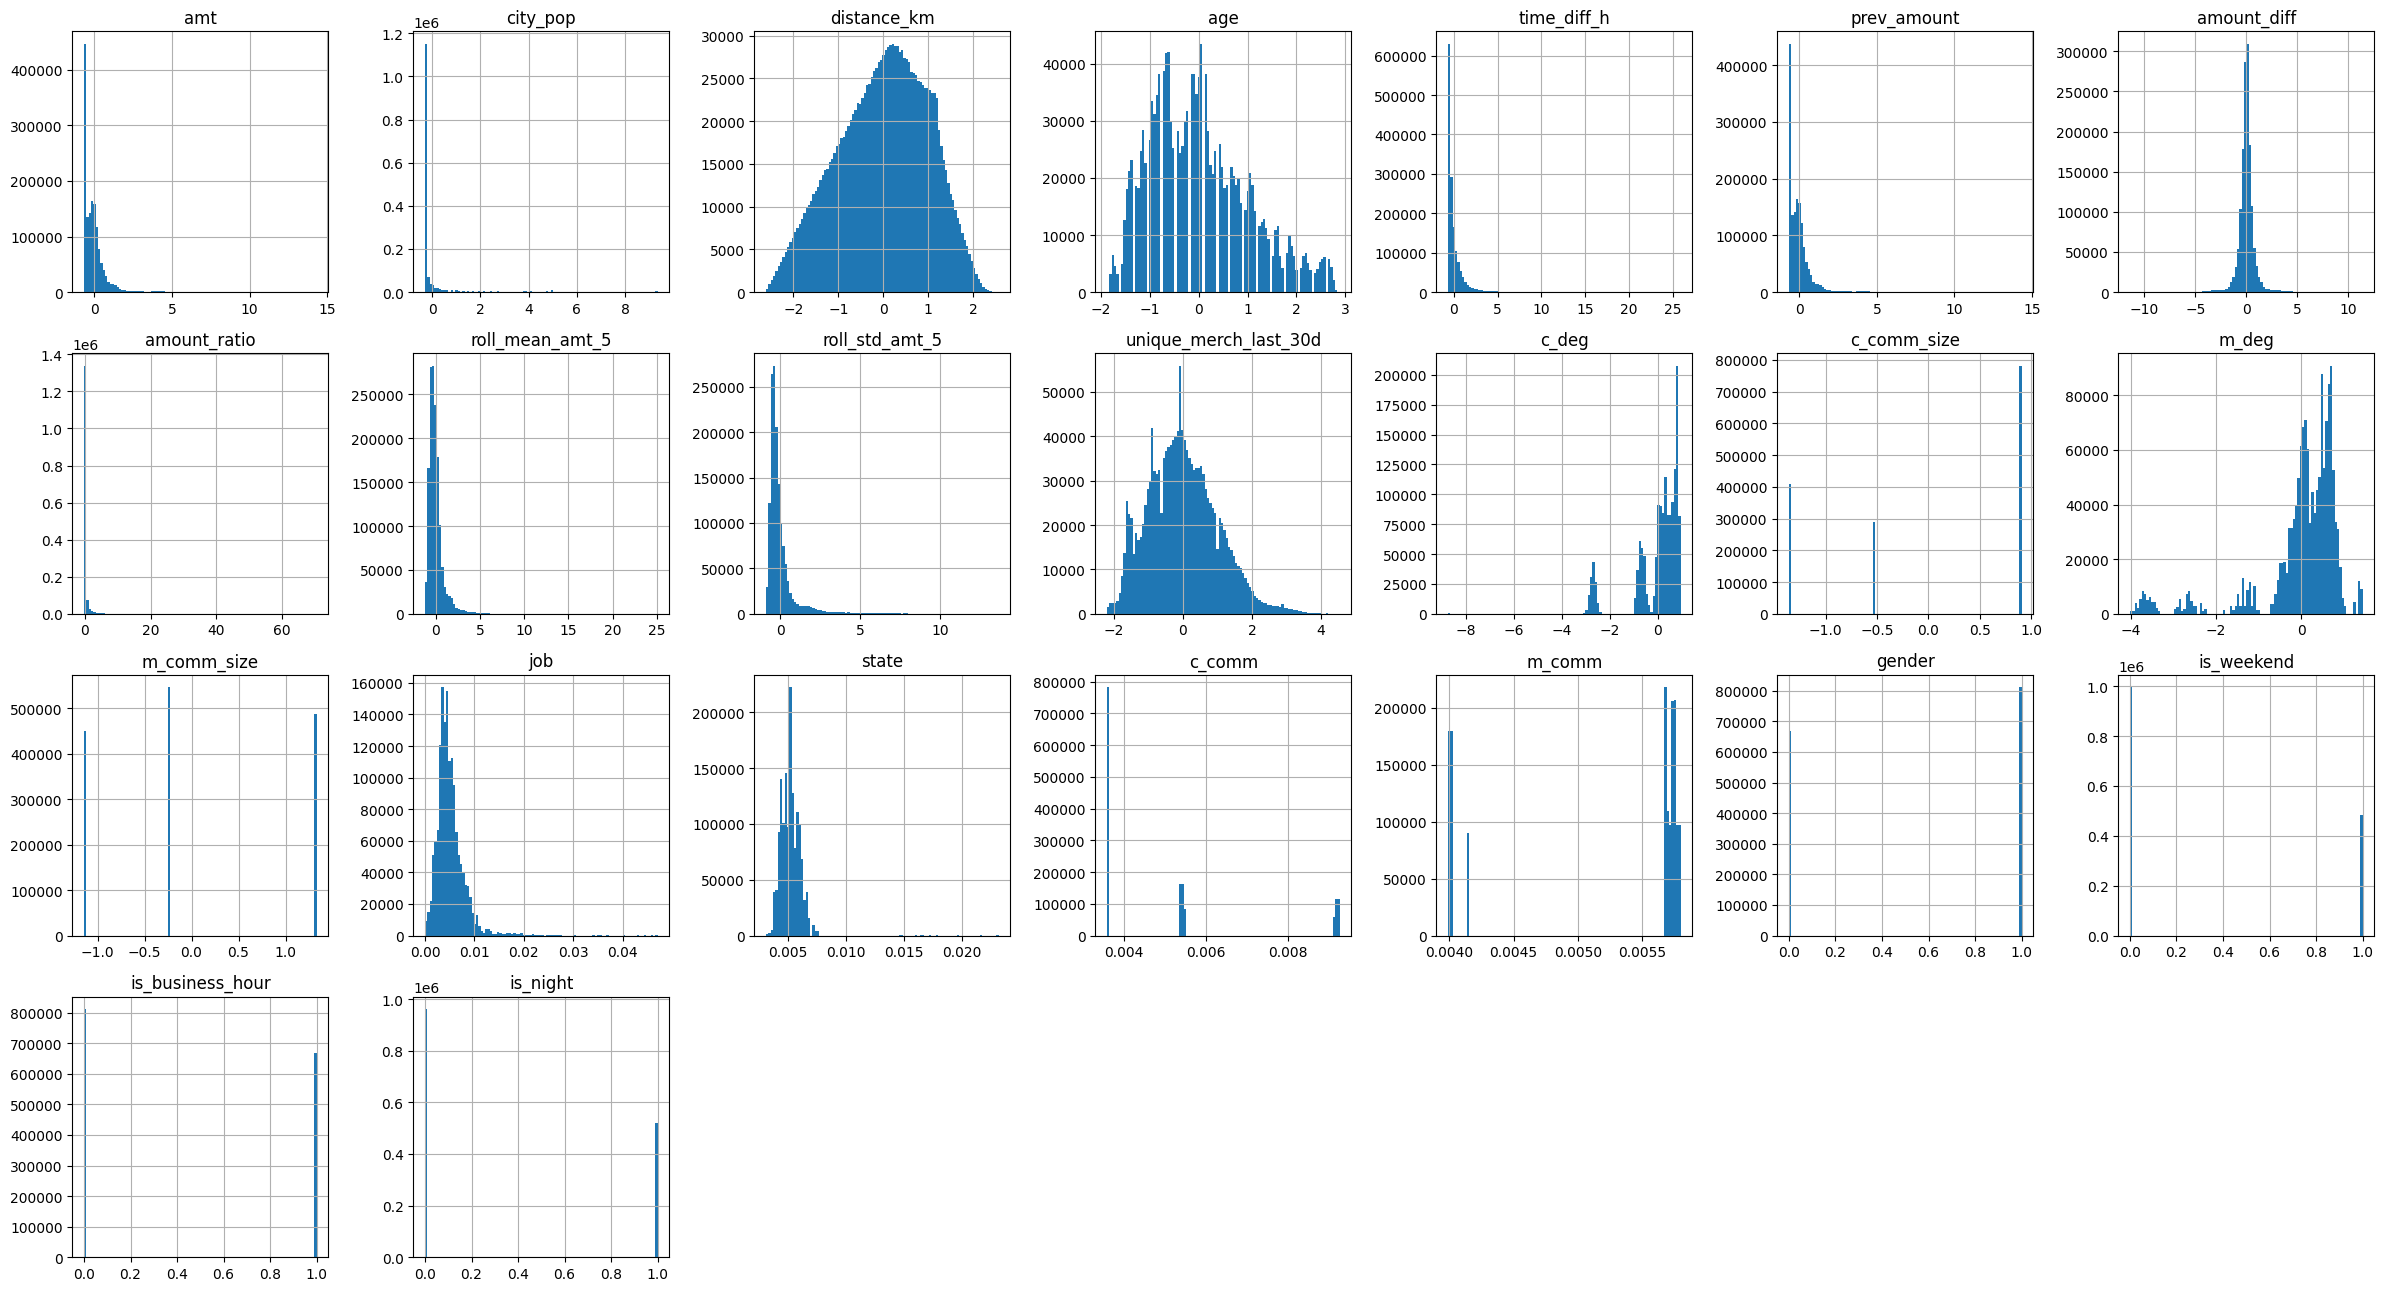

In [29]:
training_df[
    [
        col
        for col in ALL_USED_COLUMNS
        if not col.startswith("category_")
        and not col.startswith("dayofweek_")
        and not col.startswith("emb_")
        and not col.startswith("month_")
        and not col.startswith("hour_")
    ]
].hist(layout=(5, 7), figsize=(24, 16), sharex=False, sharey=False, bins=100)
plt.tight_layout()
plt.show()

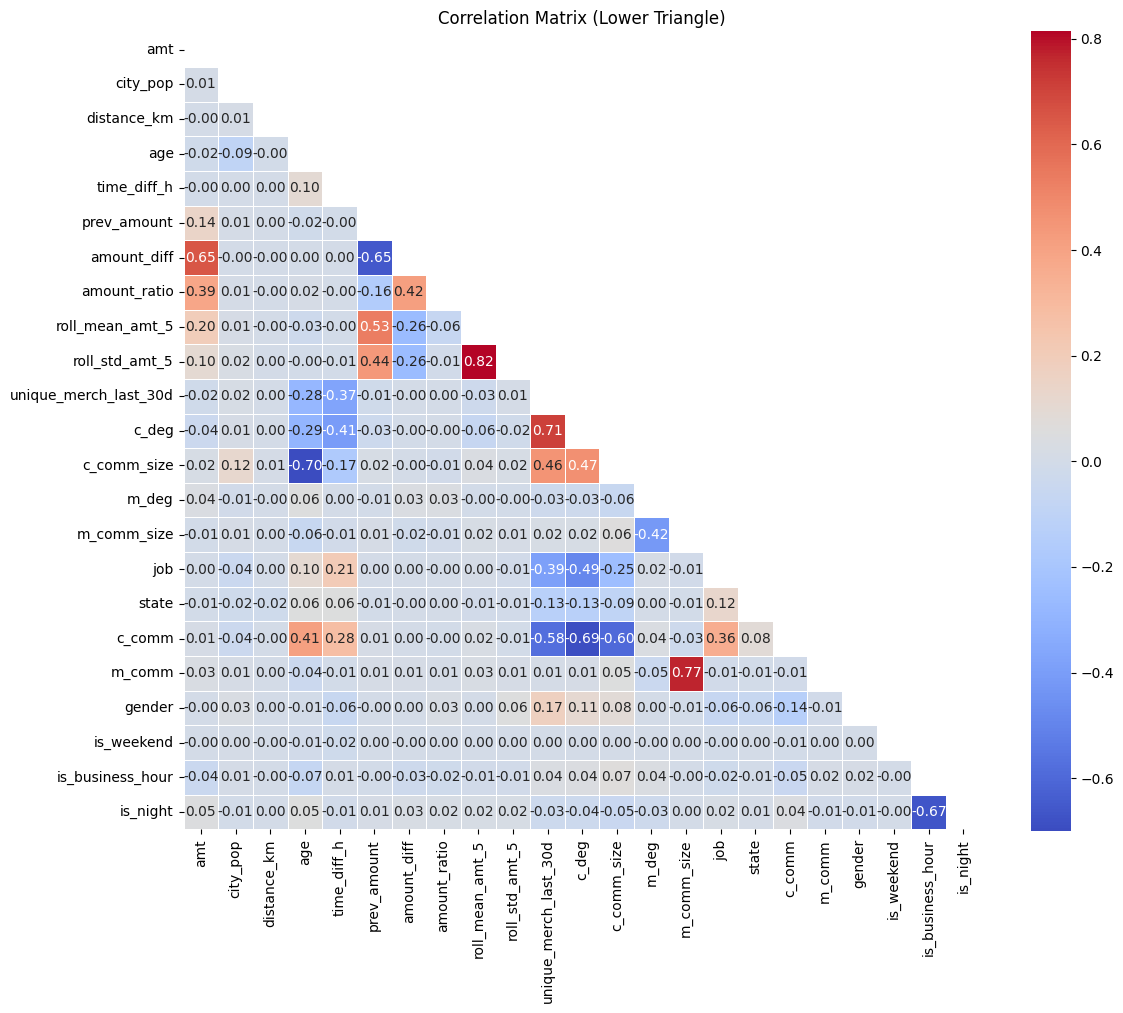

In [30]:
import seaborn as sns

corr = training_df[
    [
        col
        for col in ALL_USED_COLUMNS
        if not col.startswith("category_")
        and not col.startswith("dayofweek_")
        and not col.startswith("emb_")
        and not col.startswith("month_")
        and not col.startswith("hour_")
    ]
].corr()

# –°–æ–∑–¥–∞–Ω–∏–µ –º–∞—Å–∫–∏ –¥–ª—è –≤–µ—Ä—Ö–Ω–µ–π —Ç—Ä–µ—É–≥–æ–ª—å–Ω–æ–π —á–∞—Å—Ç–∏
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", square=True, linewidths=0.5
)
plt.title("Correlation Matrix (Lower Triangle)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# –û–±—É—á–µ–Ω–∏–µ –∫–ª–∞—Å—Å–∏—á–µ—Å–∫–∏—Ö –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤

In [31]:
n_folds = 5

In [32]:
print("GridSearchCV –¥–ª—è LogisticRegression...")
param_grid_lr = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "penalty": ["l2"],
    "solver": ["liblinear"],
}
clf_lr = LogisticRegression(class_weight="balanced", max_iter=1000)

n_trials_lr = (
    len(param_grid_lr["C"])
    * len(param_grid_lr["penalty"])
    * len(param_grid_lr["solver"])
)
gs_lr = GridSearchCV(
    clf_lr, param_grid_lr, scoring="roc_auc", cv=n_folds, n_jobs=-1, verbose=5
)
gs_lr.fit(X_train_processed, y_train)

print(f"Best LR params: {gs_lr.best_params_}")
print(f"Best LR AUC: {gs_lr.best_score_}\n")

GridSearchCV –¥–ª—è LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.990 total time=  14.7s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.987 total time=  15.1s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.989 total time=  15.7s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.989 total time=  16.4s
[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.990 total time=  18.7s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.990 total time=  21.1s
[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.989 total time=  22.6s
[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.988 total time=  23.4s
[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.990 total time=  23.6s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.989 total time=  23.9s
[CV 4/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.990 total time=  27.3s
[CV 3/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.990 total time=  28.4s
[CV 2/5] EN

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score


def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [50, 100]),
        "depth": trial.suggest_int("depth", 4, 12, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        "random_state": 42,
        "verbose": 0,
        "devices": "7",
        "task_type": "GPU",
    }
    model = CatBoostClassifier(**params)
    scores = cross_val_score(
        model, X_train_processed, y_train, cv=n_folds, scoring="roc_auc", n_jobs=1
    )
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, show_progress_bar=True, timeout=600)
best_params_cb_no_graph = study.best_params.copy()

best_cb_model_cb_no_graph = CatBoostClassifier(**best_params_cb_no_graph)
best_cb_model_cb_no_graph.fit(
    X_train_processed, y_train, eval_set=(X_test_processed, y_test), verbose=0
)

print(f"Best Optuna params: {study.best_params}")
print(f"Best Optuna AUC:    {study.best_value:.4f}")

[I 2025-05-18 07:40:53,338] A new study created in memory with name: no-name-1eba666f-92b8-484e-a17d-181a1e2952b2
Best trial: 0. Best value: 0.989911:   19%|‚ñà‚ñä        | 01:51/10:00

[I 2025-05-18 07:42:44,478] Trial 0 finished with value: 0.9899111458729534 and parameters: {'iterations': 100, 'depth': 4, 'learning_rate': 0.012215634382817869}. Best is trial 0 with value: 0.9899111458729534.


Best trial: 1. Best value: 0.998242:   41%|‚ñà‚ñà‚ñà‚ñà      | 04:06/10:00

[I 2025-05-18 07:45:00,137] Trial 1 finished with value: 0.9982424898796026 and parameters: {'iterations': 100, 'depth': 12, 'learning_rate': 0.03401059058933645}. Best is trial 1 with value: 0.9982424898796026.


Best trial: 1. Best value: 0.998242:   61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 06:07/10:00

[I 2025-05-18 07:47:00,506] Trial 2 finished with value: 0.9977875850673266 and parameters: {'iterations': 50, 'depth': 12, 'learning_rate': 0.041756321396819805}. Best is trial 1 with value: 0.9982424898796026.


Best trial: 1. Best value: 0.998242:   79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 07:55/10:00

[I 2025-05-18 07:48:49,217] Trial 3 finished with value: 0.9954879216595642 and parameters: {'iterations': 50, 'depth': 4, 'learning_rate': 0.08186153174954144}. Best is trial 1 with value: 0.9982424898796026.


Best trial: 4. Best value: 0.999081:   99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 09:51/10:00

[I 2025-05-18 07:50:44,754] Trial 4 finished with value: 0.9990805630504171 and parameters: {'iterations': 100, 'depth': 10, 'learning_rate': 0.08660067945295999}. Best is trial 4 with value: 0.9990805630504171.


Best trial: 4. Best value: 0.999081:  100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11:51/10:00


[I 2025-05-18 07:52:44,962] Trial 5 finished with value: 0.9969189601612441 and parameters: {'iterations': 50, 'depth': 12, 'learning_rate': 0.022747189936240732}. Best is trial 4 with value: 0.9990805630504171.
Best Optuna params: {'iterations': 100, 'depth': 10, 'learning_rate': 0.08660067945295999}
Best Optuna AUC:    0.9991


In [35]:
def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [50, 100]),
        "depth": trial.suggest_int("depth", 4, 12, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        "random_state": 42,
        "verbose": 0,
        "devices": "7",
        "task_type": "GPU",
    }
    model = CatBoostClassifier(**params)
    scores = cross_val_score(
        model,
        X_train_processed_graph,
        y_train_graph,
        cv=n_folds,
        scoring="roc_auc",
        n_jobs=1,
    )
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=1200, show_progress_bar=True)

best_params_cb_graph = study.best_params.copy()

best_cb_model_cb_graph = CatBoostClassifier(**best_params_cb_graph)
best_cb_model_cb_graph.fit(
    X_train_processed_graph,
    y_train_graph,
    eval_set=(X_test_processed_graph, y_test_graph),
    verbose=0,
)

print(f"Best Optuna params: {study.best_params}")
print(f"Best Optuna AUC:    {study.best_value:.4f}")

[I 2025-05-18 07:53:34,386] A new study created in memory with name: no-name-cd2ea8ac-700d-4101-aebb-84a869ae199b
Best trial: 0. Best value: 0.989597:   25%|‚ñà‚ñà‚ñç       | 04:54/20:00

[I 2025-05-18 07:58:28,651] Trial 0 finished with value: 0.9895974703798591 and parameters: {'iterations': 100, 'depth': 4, 'learning_rate': 0.010834594265698444}. Best is trial 0 with value: 0.9895974703798591.


Best trial: 1. Best value: 0.997405:   52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 10:26/20:00

[I 2025-05-18 08:04:00,404] Trial 1 finished with value: 0.9974045352950378 and parameters: {'iterations': 100, 'depth': 12, 'learning_rate': 0.017460715860935068}. Best is trial 1 with value: 0.9974045352950378.


Best trial: 2. Best value: 0.998475:   78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 15:31/20:00

[I 2025-05-18 08:09:06,125] Trial 2 finished with value: 0.9984746389390754 and parameters: {'iterations': 100, 'depth': 10, 'learning_rate': 0.05031462850947768}. Best is trial 2 with value: 0.9984746389390754.


Best trial: 2. Best value: 0.998475:  100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20:29/20:00


[I 2025-05-18 08:14:04,264] Trial 3 finished with value: 0.9973603228661346 and parameters: {'iterations': 50, 'depth': 10, 'learning_rate': 0.039658943015230354}. Best is trial 2 with value: 0.9984746389390754.
Best Optuna params: {'iterations': 100, 'depth': 10, 'learning_rate': 0.05031462850947768}
Best Optuna AUC:    0.9985


# GNN

In [36]:
prep = FraudDataPreprocessor(gnn_prepare=True)
X_train_processed_gnn, X_test_processed_gnn, y_train_gnn, y_test_gnn = (
    prep.fit_transform(df_feat)
)
training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


–£–¥–∞–ª–µ–Ω–∏–µ –∏–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ü–∏–æ–Ω–Ω—ã—Ö –∫–æ–ª–æ–Ω–æ–∫ (cc_num –∏ merchant), –æ–Ω–∏ –±—ã–ª–∏ –Ω—É–∂–Ω–æ, —á—Ç–æ–±—ã —Å–æ–∑–¥–∞—Ç—å –¥–∞—Ç–∞—Ñ—Ä–µ–π–º—ã, –∏–∑ –∫–æ—Ç–æ—Ä—ã—Ö –ø–æ–∑–¥–Ω–µ–µ –±—É–¥–µ—Ç —Å–æ–∑–¥–∞–≤–∞—Ç—å—Å—è –≥—Ä–∞—Ñ

In [37]:
X_train_processed_gnn = np.delete(X_train_processed_gnn, [-1, -2], axis=1)
X_test_processed_gnn = np.delete(X_test_processed_gnn, [-1, -2], axis=1)


–ò–∑-–∑–∞ –Ω–∞–ª–∏—á–∏—è —Ç–µ–∫—Å—Ç–æ–≤–æ–π –∫–æ–ª–æ–Ω–∫–∏ "—Å–ª–æ–º–∞–ª–∏—Å—å" —Ç–∏–ø—ã, –≤–æ–∑–≤—Ä–∞—â–∞–µ–º –æ–±—Ä–∞—Ç–Ω–æ –∫ —á–∏—Å–ª–æ–≤—ã–º

In [38]:
obj_cols = training_df.select_dtypes(include="object").columns.tolist()
cat_cols = training_df.select_dtypes(include="category").columns.tolist()
obj_cols.remove("merchant")

for c in obj_cols + cat_cols:
    training_df[c] = pd.to_numeric(training_df[c], errors="coerce")

training_df[obj_cols] = training_df[obj_cols].fillna(0)

In [39]:
obj_cols = test_df.select_dtypes(include="object").columns.tolist()
cat_cols = test_df.select_dtypes(include="category").columns.tolist()
obj_cols.remove("merchant")

for c in obj_cols + cat_cols:
    test_df[c] = pd.to_numeric(test_df[c], errors="coerce")

test_df[obj_cols] = test_df[obj_cols].fillna(0)

In [40]:
training_df["is_fraud"] = y_train_gnn.values
test_df["is_fraud"] = y_test.values

–§—É–Ω–∫—Ü–∏—è –Ω–∏–∂–µ - –ø—Ä–∏–≤–µ–¥–µ–Ω–∏–µ –∏–º–µ—é—â–∏—Ö—Å—è –¥–∞–Ω–Ω—ã—Ö –≤ –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã–π PyTorch —Ñ–æ—Ä–º–∞—Ç: –∏–Ω–¥–µ–∫—Å–∞—Ü–∏—è —É–∑–ª–æ–≤ –∏ —Ä–µ–±–µ—Ä, —Ä–∞–∑–±–∏–µ–Ω–∏–µ —Ñ–∏—á–µ–π –Ω–∞ —É–∑–ª–æ–≤—ã–µ –∏ —Ä–µ–±–µ—Ä–Ω—ã–µ, –∞ —Ç–∞–∫–∂–µ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∫ –±—É–¥—É—â–µ–º—É –∞–Ω—Å–∞–º–±–ª–∏—Ä–æ–≤–∞–Ω–∏—é –≤ –≤–∏–¥—É subtrain –º–∞—Å–∫–∏

In [41]:
import torch
from torch_geometric.data import Data


def prepare_edge_gnn_data(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    node_feat_cols: list[str],
    edge_feat_cols: list[str],
    node_id_cols: tuple[str, str] = ("cc_num", "merchant"),
    target_col: str = "is_fraud",
) -> tuple[Data, Data]:
    # ---- –∏–Ω–¥–µ–∫—Å–∞—Ü–∏—è —É–∑–ª–æ–≤ –ø–æ –æ–±—ä–µ–¥–∏–Ω—ë–Ω–Ω–æ–º—É df ----
    df_all = pd.concat([df_train, df_test], ignore_index=True)
    left_name, right_name = node_id_cols
    left_ids = df_all[left_name].unique()
    right_ids = df_all[right_name].unique()
    cc2idx = {cc: i for i, cc in enumerate(left_ids)}
    m2idx = {m: i + len(left_ids) for i, m in enumerate(right_ids)}
    num_nodes = len(left_ids) + len(right_ids)

    # ---- node feature matrix x ----

    x = torch.zeros(num_nodes, len(node_feat_cols), dtype=torch.float64)
    node_df = (
        df_all[[left_name] + node_feat_cols]
        .drop_duplicates(left_name)
        .set_index(left_name)[node_feat_cols]
    )
    for node_id, row in node_df.iterrows():
        x[cc2idx[node_id]] = torch.tensor(row.values, dtype=torch.float64)

    # ---- –≤—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è ----
    def build_data(df: pd.DataFrame, is_train: bool = True) -> Data:
        src = df[left_name].map(cc2idx).to_numpy()
        dst = df[right_name].map(m2idx).to_numpy()
        edge_index = torch.tensor([src, dst], dtype=torch.long)
        edge_attr = torch.tensor(df[edge_feat_cols].values, dtype=torch.float64)
        y_edge = torch.tensor(df[target_col].values, dtype=torch.float64)

        data = Data(
            num_nodes=num_nodes,
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y_edge=y_edge,
        )
        if is_train:
            data.train_mask = torch.ones(len(df), dtype=torch.bool)
        else:
            data.test_mask = torch.ones(len(df), dtype=torch.bool)
        return data

    data_train = build_data(df_train, is_train=True)
    data_test = build_data(df_test, is_train=False)

    idx_all = np.where(data_train.train_mask.cpu())[0]
    idx_subtrain, idx_val = train_test_split(
        idx_all,
        test_size=0.20,
        stratify=data_train.y_edge[idx_all].cpu().numpy(),
        random_state=42,
    )

    data_train.subtrain_mask = torch.zeros(data_train.num_edges, dtype=torch.bool)
    data_train.val_mask = torch.zeros(data_train.num_edges, dtype=torch.bool)
    data_train.subtrain_mask[idx_subtrain] = True
    data_train.val_mask[idx_val] = True

    return data_train, data_test, idx_subtrain, idx_val

In [42]:
def expand_cols(short_list: list[str], all_cols: list[str]) -> list[str]:
    expanded = []
    for base in short_list:
        if base in all_cols:
            expanded.append(base)
        else:
            expanded.extend([c for c in all_cols if c.startswith(f"{base}_")])
    return expanded


# --- 2. –±–∞–∑–æ–≤—ã–µ ¬´—à–æ—Ä—Ç-–ª–∏—Å—Ç—ã¬ª ---------------------------------------------
node_base = ["age", "city_pop", "job", "state", "gender"]
edge_base = [
    "amt",
    "prev_amount",
    "amount_diff",
    "amount_ratio",
    "roll_mean_amt_5",
    "roll_std_amt_5",
    "time_diff_h",
    "dayofweek",
    "hour",
    "month",
    "is_night",
    "is_business_hour",
    "is_weekend",
    "unique_merch_last_30d",
    "category",
    "distance_km",
]


node_feats = expand_cols(node_base, ALL_USED_COLUMNS)
edge_feats = expand_cols(edge_base, ALL_USED_COLUMNS)

In [43]:
data_train, data_test, idx_subtrain, idx_val = prepare_edge_gnn_data(
    df_train=training_df,
    df_test=test_df,
    node_id_cols=("cc_num", "merchant"),
    node_feat_cols=node_feats,
    edge_feat_cols=edge_feats,
    target_col="is_fraud",
)

/tmp/ipykernel_3314827/1141522720.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([src, dst], dtype=torch.long)


In [44]:
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
)
from torch_geometric.nn import GINEConv


# TODO: —Å–¥–µ–ª–∞—Ç—å —Å–µ—Ç—å –≥–ª—É–±–∂–µ (–Ω–∞ —É–ª—É—á—à–µ–Ω–∏–∏ –∫–∞—á–µ—Å—Ç–≤–∞)
class EdgeGNN(torch.nn.Module):
    def __init__(self, in_feats, edge_feats, hidden=64):
        super().__init__()

        nn1 = torch.nn.Sequential(
            torch.nn.Linear(in_feats, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
        )
        nn2 = torch.nn.Sequential(
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
        )

        # –∫–ª—é—á ‚Äì edge_dim=edge_feats !
        self.conv1 = GINEConv(nn1, edge_dim=edge_feats)
        self.conv2 = GINEConv(nn2, edge_dim=edge_feats)

        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden + edge_feats, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, 1),
        )

    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        src, _ = edge_index
        h_edge = torch.cat([x[src], edge_attr], dim=1)
        return self.edge_mlp(h_edge).view(-1)

In [45]:
in_feats = data_train.x.size(1)
edge_feats_size = data_train.edge_attr.size(1)
model = EdgeGNN(in_feats, edge_feats_size, hidden=64)
model = model.double().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# class-imbalance: pos_weight = N_neg / N_pos
y_train_gnn_masked = data_train.y_edge[data_train.train_mask]
pos = int(y_train.sum())
neg = int(len(y_train) - pos)

pos_weight = torch.tensor((neg / pos) * 10, dtype=torch.float, device=DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()

In [46]:
def train_epoch(data):
    model.train()
    optimizer.zero_grad()

    out = model(
        data.x.to(DEVICE), data.edge_index.to(DEVICE), data.edge_attr.to(DEVICE)
    )

    loss = criterion(
        out[data.subtrain_mask], data.y_edge[data.subtrain_mask].to(DEVICE)
    )
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def evaluate(data, mask_name="val_mask"):
    model.eval()

    logits = model(
        data.x.to(DEVICE), data.edge_index.to(DEVICE), data.edge_attr.to(DEVICE)
    )

    mask = getattr(data, mask_name)
    y_true = data.y_edge[mask].cpu().numpy()
    y_prob = torch.sigmoid(logits[mask]).cpu().numpy()

    roc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    return roc, ap

In [47]:
n_epochs = 500
best_auc = 0
patience = 15
patience_cnt = 0
best_state = None

pbar = tqdm(range(1, n_epochs + 1), desc="Epochs")

for epoch in pbar:
    loss = train_epoch(data_train)

    if epoch % 2 == 0:
        auc, ap = evaluate(data_train)
        pbar.set_postfix(
            epoch=f"{epoch:03d}",
            loss=f"{loss:.4f}",
            auc=f"{auc:.4f}",
            ap=f"{ap:.4f}",
            refresh=True,
        )

        if auc > best_auc:
            best_auc = auc
            best_state = model.state_dict()
            patience_cnt = 0
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                print("Early stop.")
                break


model.load_state_dict(best_state)
torch.save(model.state_dict(), "edge_gnn_best.pt")

Epochs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [01:34<00:00,  5.31it/s, ap=0.7295, auc=0.9744, epoch=500, loss=0.0107]


## –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∫ –∞–Ω—Å–∞–º–±–ª–µ–≤–æ–º—É –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—é GNN –∏ –±—É—Å—Ç–∏–Ω–≥–∞

–ù–µ–æ–±—Ö–æ–¥–∏–º–æ –Ω–∞—É—á–∏—Ç—å—Å—è –ø–µ—Ä–µ–≤–æ–¥–∏—Ç—å –¥–∞–Ω–Ω—ã–µ, —Ö—Ä–∞–Ω—è—â–∏–µ—Å—è –≤ PyTorch –¥–∞—Ç–∞—Å–µ—Ç–µ –≤ —Ç–æ—Ç –∂–µ –≤–∏–¥, –≤ –∫–æ—Ç–æ—Ä–æ–º –∏—Ö –±—É–¥–µ—Ç –ø—Ä–∏–Ω–∏–º–∞—Ç—å –±—É—Å—Ç–∏–Ω–≥, —Ç–æ –µ—Å—Ç—å –≤ np.ndarray, –∞ —Ç–∞–∫–∂–µ —É–±–µ–¥–∏—Ç—å—Å—è, —á—Ç–æ —ç—Ç–æ - –æ–¥–Ω–∏ –∏ —Ç–µ –∂–µ –¥–∞–Ω–Ω—ã–µ.

In [48]:
import numpy as np
import pandas as pd

if "cc_num" in ALL_USED_COLUMNS:
    ALL_USED_COLUMNS.remove("cc_num")
if "merchant" in ALL_USED_COLUMNS:
    ALL_USED_COLUMNS.remove("merchant")


def convert_from_torch(data):
    global ALL_USED_COLUMNS
    src_indices, _ = data.edge_index

    src_np = src_indices.numpy()
    src_feats_np = data.x[src_np].numpy()
    edge_feats_np = data.edge_attr.numpy()

    cols = [f"{n}" for n in node_feats] + edge_feats

    all_feats = np.hstack([src_feats_np, edge_feats_np])
    prepared_to_ensemble_df = pd.DataFrame(all_feats, columns=cols)

    prepared_to_ensemble_df = prepared_to_ensemble_df[ALL_USED_COLUMNS]

    return prepared_to_ensemble_df


prepared_to_ensemble_df = convert_from_torch(data_test)

–ü—Ä–æ–≤–µ—Ä–∏–º, —á—Ç–æ –¥–∞–Ω–Ω—ã–µ —Å–æ–≤–ø–∞–¥–∞—é—Ç –∏ –≤—ã–≤–µ–¥–µ–º –∫–æ–ª–æ–Ω–∫–∏, –≤ –∫–æ—Ç–æ—Ä—ã—Ö —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –Ω–µ —Å–æ–≤–ø–∞–ª–∏

In [49]:
comp_result = pd.DataFrame(
    prepared_to_ensemble_df.to_numpy() == X_test_processed_gnn
).all()
prepared_to_ensemble_df.columns[list(comp_result[~comp_result].index)]

Index(['age', 'job', 'state'], dtype='object')

–ú–æ–∂–Ω–æ –∑–∞–º–µ—Ç–∏—Ç—å, —á—Ç–æ –ø–æ–ª—É—á–µ–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –æ—Ç–ª–∏—á–∞—é—Ç—Å—è –æ—Ç –ø–æ–¥–≥–æ—Ç–æ–≤–ª–µ–Ω–Ω—ã—Ö —Ä–∞–Ω–µ–µ –ø–æ –≤–æ–∑—Ä–∞—Å—Ç—É, –∞ —Ç–∞–∫–∂–µ –∫–æ–ª–æ–Ω–∫–∞–º, –ø–æ–º–µ—á–µ–Ω–Ω—ã–º —Ä–∞–Ω–µ–µ, –∫–∞–∫ –≤—ã—Å–æ–∫–æ–∫–∞—Ä–¥–∏–Ω–∞–ª—å–Ω—ã–µ. –≠—Ç–æ —Å–≤—è–∑–∞–Ω–æ —Å —Ç–µ–º, —á—Ç–æ –∫–∞–∂–¥—ã–π –¥–µ—Ä–∂–∞—Ç–µ–ª—å –∫–∞—Ä—Ç—ã –¥–æ–±–∞–≤–ª—è–ª—Å—è –≤ –≥—Ä–∞—Ñ –µ–¥–∏–Ω–æ–∂–¥—ã, –∞ –≤—ã—Å–æ–∫–æ–∫–∞—Ä–¥–∏–Ω–∞–ª—å–Ω—ã–µ —Ñ–∏—á–∏ –∏–º–µ—é—Ç —Ä–∞–∑–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è, —Ç–∞–∫ –∫–∞–∫ –±—ã–ª–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–æ OOF-–∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏–µ. –í–æ–∑—Ä–∞—Å—Ç –∂–µ –æ—Ç–ª—á–∏–∞–µ—Ç—Å—è, –ø–æ—Ç–æ–º—É —á—Ç–æ –¥–∞–Ω–Ω—ã–µ –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª–µ–Ω—ã –∑–∞ –≥–æ–¥ –∏ –≤–æ–∑—Ä–∞—Å—Ç –¥–µ—Ä–∂–∞—Ç–µ–ª–µ–π –∫–∞—Ä—Ç –∑–∞ –≥–æ–¥, –æ—á–µ–≤–∏–¥–Ω–æ, –∏–∑–º–µ–Ω–∏–ª—Å—è.

In [50]:
X_train_gnn = convert_from_torch(data_train).to_numpy()
X_test_gnn = convert_from_torch(data_test).to_numpy()

## –û–±—É—á–µ–Ω–∏–µ –∞–Ω—Å–∞–º–±–ª—è

In [51]:
if not isinstance(y_train_gnn, np.ndarray):
    y_train_gnn = y_train_gnn.to_numpy()

X_subtrain_gnn = X_train_gnn[idx_subtrain]
y_subtrain_gnn = y_train_gnn[idx_subtrain]

X_val_gnn = X_train_gnn[idx_val]
y_val_gnn = y_train_gnn[idx_val]

In [63]:
boosting_ensemble_classifier = CatBoostClassifier(
    verbose=20,
    random_state=42,
    depth=10,
    iterations=250,
    learning_rate=0.1,
    eval_metric="F:beta=2",
    task_type="GPU",
    devices="7",
)

boosting_ensemble_classifier.fit(X_subtrain_gnn, y_subtrain_gnn)
print(f"  Best CB AUC: {boosting_ensemble_classifier.get_best_score()}")

Default metric period is 5 because F is/are not implemented for GPU
Metric F:beta=2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6909608	total: 24.7ms	remaining: 6.15s
20:	learn: 0.8432483	total: 512ms	remaining: 5.58s
40:	learn: 0.8824605	total: 926ms	remaining: 4.72s
60:	learn: 0.9130220	total: 1.34s	remaining: 4.16s
80:	learn: 0.9304505	total: 1.75s	remaining: 3.66s
100:	learn: 0.9427372	total: 2.17s	remaining: 3.2s
120:	learn: 0.9498854	total: 2.59s	remaining: 2.76s
140:	learn: 0.9563682	total: 3.01s	remaining: 2.32s
160:	learn: 0.9628638	total: 3.41s	remaining: 1.89s
180:	learn: 0.9697671	total: 3.83s	remaining: 1.46s
200:	learn: 0.9745569	total: 4.25s	remaining: 1.03s
220:	learn: 0.9770789	total: 4.65s	remaining: 610ms
240:	learn: 0.9804464	total: 5.05s	remaining: 189ms
249:	learn: 0.9812309	total: 5.24s	remaining: 0us
  Best CB AUC: {'learn': {'Logloss': 0.000709054731997712, 'F:beta=2': 0.9812308893370634}}


In [64]:
with torch.no_grad():
    logits_val = model(
        data_train.x.to(DEVICE),
        data_train.edge_index.to(DEVICE),
        data_train.edge_attr.to(DEVICE),
    )
p_gnn_val = torch.sigmoid(logits_val[data_train.val_mask]).cpu().numpy()

In [65]:
p_cb_val = boosting_ensemble_classifier.predict_proba(X_val_gnn)[:, 1]

In [66]:
from sklearn.linear_model import LogisticRegression

X_meta_val = np.column_stack([p_gnn_val, p_cb_val])

meta = LogisticRegression(max_iter=1000, class_weight="balanced")
meta.fit(X_meta_val, y_val_gnn)

LogisticRegression(class_weight='balanced', max_iter=1000)

# Validation

In [67]:
import numpy as np
from sklearn.metrics import (
    fbeta_score,
    precision_score,
    recall_score,
)


def _best_threshold_fbeta(y_true: np.ndarray, y_prob: np.ndarray, beta: float = 2.0):
    order = np.argsort(-y_prob)
    y_sorted = y_true[order]
    p_sorted = y_prob[order]

    tp = np.cumsum(y_sorted)
    fp = np.cumsum(1 - y_sorted)
    fn = tp[-1] - tp

    beta2 = beta * beta
    fbeta = (1 + beta2) * tp / ((1 + beta2) * tp + beta2 * fn + fp)

    i_best = int(np.nanargmax(fbeta))
    tau_best = p_sorted[i_best]
    return tau_best, fbeta[i_best]


def perform_analysis(y_true, y_prob, beta_for_opt: float = 2.0, verbose: bool = True):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob, dtype=float)

    tau_opt, best_fbeta = _best_threshold_fbeta(y_true, y_prob, beta=beta_for_opt)

    y_pred = (y_prob >= tau_opt).astype(int)

    f2 = fbeta_score(y_true, y_pred, beta=2)
    f1 = fbeta_score(y_true, y_pred, beta=1)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)

    if verbose:
        print(f"Optimal threshold (beta={beta_for_opt}) : {tau_opt:.4f}")
        print(f"F{beta_for_opt:.0f}-score (at œÑ_opt)  : {best_fbeta:.4f}")
        print(f"F2-score               : {f2:.4f}")
        print(f"F1-score               : {f1:.4f}")
        print(f"ROC AUC                : {roc_auc:.4f}")
        print(f"Recall                 : {recall:.4f}")
        print(f"Precision              : {precision:.4f}")

    return (
        {
            "threshold": tau_opt,
            f"F{int(beta_for_opt)}": best_fbeta,
            "F2": f2,
            "F1": f1,
            "ROC_AUC": roc_auc,
            "Recall": recall,
            "Precision": precision,
        }
        if not verbose
        else None
    )

## –õ–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è

In [68]:
lr_result_proba = gs_lr.predict_proba(X_test_processed)[:, 1]
perform_analysis(y_test, lr_result_proba)

Optimal threshold (beta=2.0) : 0.9732
F2-score (at œÑ_opt)  : 0.6830
F2-score               : 0.6830
F1-score               : 0.6050
ROC AUC                : 0.9871
Recall                 : 0.7472
Precision              : 0.5083


## –ë—É—Å—Ç–∏–Ω–≥ –±–µ–∑ –≥—Ä–∞—Ñ–æ–≤—ã—Ö —Ñ–∏—á–µ–π

In [69]:
boosting_no_graph_result_proba = best_cb_model_cb_no_graph.predict_proba(
    X_test_processed
)[:, 1]

perform_analysis(y_test, boosting_no_graph_result_proba)

Optimal threshold (beta=2.0) : 0.1638
F2-score (at œÑ_opt)  : 0.9324
F2-score               : 0.9324
F1-score               : 0.9213
ROC AUC                : 0.9990
Recall                 : 0.9399
Precision              : 0.9034


## –ë—É—Å—Ç–∏–Ω–≥ —Å –≥—Ä–∞—Ñ–æ–≤—ã–º–∏ —Ñ–∏—á–∞–º–∏

In [70]:
boosting_with_graph_result_proba = best_cb_model_cb_graph.predict_proba(
    X_test_processed_graph
)[:, 1]

perform_analysis(y_test_graph, boosting_with_graph_result_proba)

Optimal threshold (beta=2.0) : 0.1411
F2-score (at œÑ_opt)  : 0.9138
F2-score               : 0.9138
F1-score               : 0.8933
ROC AUC                : 0.9982
Recall                 : 0.9280
Precision              : 0.8611


## GNN

In [71]:
with torch.no_grad():
    model.eval()
    logits = model(
        data_test.x.to(DEVICE),
        data_test.edge_index.to(DEVICE),
        data_test.edge_attr.to(DEVICE),
    )
    y_prob_gnn = torch.sigmoid(logits[data_test.test_mask]).cpu().numpy()

perform_analysis(y_test_gnn, y_prob_gnn)


Optimal threshold (beta=2.0) : 0.1609
F2-score (at œÑ_opt)  : 0.6759
F2-score               : 0.6759
F1-score               : 0.6592
ROC AUC                : 0.9725
Recall                 : 0.6876
Precision              : 0.6331


## GNN + –±—É—Å—Ç–∏–Ω–≥

In [72]:
boosting_ensemble_classifier_probs = boosting_ensemble_classifier.predict_proba(
    X_test_gnn
)[:, 1]

X_meta_test = np.column_stack([y_prob_gnn, boosting_ensemble_classifier_probs])

y_prob_ensemble = meta.predict_proba(X_meta_test)[:, 1]

perform_analysis(y_test_gnn, y_prob_ensemble)


Optimal threshold (beta=2.0) : 0.9986
F2-score (at œÑ_opt)  : 0.9427
F2-score               : 0.9427
F1-score               : 0.9346
ROC AUC                : 0.9993
Recall                 : 0.9482
Precision              : 0.9215


# –í—ã–≤–æ–¥

–ù–∞–∏–ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ–∫–∞–∑–∞–ª –∫–æ–º–ø–ª–µ–∫—Å–Ω—ã–π –ø–æ–¥—Ö–æ–¥, –∏—Å–ø–æ–ª—å–∑—É—é—â–∏–π –≥—Ä–∞—Ñ–æ–≤—É—é –Ω–µ–π—Ä–æ–Ω–Ω—É—é —Å–µ—Ç—å –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ä–µ–±–µ—Ä, –∞ —Ç–∞–∫–∂–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω—ã–π –±—É—Å—Ç–∏–Ω–≥, –≤—ã—Ö–æ–¥–Ω—ã–µ –≤—Ä–µ–æ—è—Ç–Ω–æ—Å—Ç–∏ –ø—Ä–æ–ø—É—Å–∫–∞—é—Ç—Å—è —á–µ—Ä–µ–∑ –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫—É—é —Ä–µ–≥—Ä–µ—Å—Å–∏—é –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è —Ñ–∏–Ω–∞–ª—å–Ω–æ–≥–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞. –ö—Ä–æ–º–µ —Ü–µ–ª–µ–≤–æ–π –º–µ—Ç—Ä–∏–∫–∏ (F2Score), —ç—Ç–æ—Ç –∞–ª–≥–æ—Ä–∏—Ç–º –∏–º–µ–µ—Ç —Å–∞–º—ã–π –≤—ã—Å–æ–∫–∏–π precision, —á—Ç–æ –ø–æ–∑–≤–æ–ª—è–µ—Ç –¥–æ—Å—Ç–∏—á—å –ø–æ—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã—Ö –ø—Ä–æ–¥—É–∫—Ç–æ–≤—ã—Ö —Ü–µ–ª–µ–π –ø–æ —É–º–µ–Ω—å—à–µ–Ω–∏—é –ª–æ–∂–Ω–æ-–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã—Ö —Å—Ä–∞–±–∞—Ç—ã–≤–∞–Ω–∏–π. –í –¥–∞–ª—å–Ω–µ–π—à–µ–π —Ä–∞–±–æ—Ç–µ –ø–ª–∞–Ω–∏—Ä—É–µ—Ç—Å—è –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Å–≤—è–∑–∫–∏ (GNN + CatBoost -> LogisticRegression)